# Análise de segmentação de municípios - final
## Modelos de árvores e ensemble + clustering + prediction

#### Problemas de análise
* Quais são os valores previstos de cobertura vacinal de BCG nos municípios brasileiros?
* Quais são as variáveis mais importantes na previsão das CV de BCG?

#### Dados
* RNDS, ICGE, SAPS Sinan-TB

In [984]:
# Bibliotecas

# Análise de dados
import numpy as np
import pandas as pd
import math

# Análise espacial
import geopandas as gpd
from pysal.explore import esda
from pysal.lib import weights

# visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns

# Aprendizado de máquina
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, mean_absolute_error, mean_squared_error
from scipy.spatial.distance import pdist
import scipy.cluster.hierarchy as shc

# Teste de Bartlett
import scipy.stats as bartlett

# Dados

In [985]:
# Dados
dados = pd.read_csv("dados_socioeconomicos_aps_bcg_tb.csv", sep = ';')
dados.head()

,COD,MUNI,cv_bcg,prop_populacao_com_renda_menosqmeio_SM,prop_populacao_pobreza_extrema,Renda_media_domic_per_capita,Taxa_de_analfabetismo,Taxa_de_desemprego_16a_emais,PIB_per_capita,Saneamento_inadequado,Taxa_urbanizacao,Gini,CoberturaESF,CoberturaAB,Inc_tb22,mort_tb22,prop_cont22,populacao_residente
0,110001,ALTA FLORESTA D'OESTE,114.41,48.42,7.70,306,12.0,5.01,13231.01,40.94,57.27,0.5893,90.22,90.22,4.441286,4.441286,40.000000,22516
1,110002,ARIQUEMES,112.61,31.05,2.99,349,7.9,4.64,17566.27,14.46,84.70,0.5496,44.78,44.78,24.291935,1.799403,78.571426,111148
2,110003,CABIXI,94.2,48.17,4.00,324,13.8,2.49,14828.03,31.14,42.66,0.5166,100.00,100.00,39.471088,0.000000,0.000000,5067
3,110004,CACOAL,124.6,32.10,3.65,367,8.3,5.87,16480.36,18.56,78.81,0.5890,68.71,89.90,17.357897,0.000000,84.210526,86416
4,110005,CEREJEIRAS,110.78,36.99,4.17,401,10.4,5.24,18918.80,19.97,84.67,0.5147,84.54,84.54,18.647440,0.000000,100.000000,16088


# Tratamento de dados

In [986]:
tem_nulos = dados['cv_bcg'].isnull().any()

if tem_nulos:
    print("A coluna tem valores nulos")
else:
    print("A coluna não tem valores nulos")

A coluna não tem valores nulos


In [987]:
print('Feições dos dados:', dados.shape)
print(dados.dtypes)

Feições dos dados: (5570, 18)
COD                                         int64
MUNI                                       object
cv_bcg                                     object
prop_populacao_com_renda_menosqmeio_SM    float64
prop_populacao_pobreza_extrema            float64
Renda_media_domic_per_capita                int64
Taxa_de_analfabetismo                     float64
Taxa_de_desemprego_16a_emais              float64
PIB_per_capita                            float64
Saneamento_inadequado                     float64
Taxa_urbanizacao                          float64
Gini                                      float64
CoberturaESF                              float64
CoberturaAB                               float64
Inc_tb22                                  float64
mort_tb22                                 float64
prop_cont22                               float64
populacao_residente                         int64
dtype: object


In [988]:
# Transformar NA em 0
dados = dados.replace(np.nan, 0)

# Transformar valores > 100 em 100%
dados['cv_bcg'] = pd.to_numeric(dados['cv_bcg'], errors = 'coerce')
dados['cv_bcg'] = dados['cv_bcg'].clip(upper = 100)
print(dados.dtypes)

COD                                         int64
MUNI                                       object
cv_bcg                                    float64
prop_populacao_com_renda_menosqmeio_SM    float64
prop_populacao_pobreza_extrema            float64
Renda_media_domic_per_capita                int64
Taxa_de_analfabetismo                     float64
Taxa_de_desemprego_16a_emais              float64
PIB_per_capita                            float64
Saneamento_inadequado                     float64
Taxa_urbanizacao                          float64
Gini                                      float64
CoberturaESF                              float64
CoberturaAB                               float64
Inc_tb22                                  float64
mort_tb22                                 float64
prop_cont22                               float64
populacao_residente                         int64
dtype: object


In [989]:
dados['Gini'] = dados['Gini'] * 100
dados.head()

,COD,MUNI,cv_bcg,prop_populacao_com_renda_menosqmeio_SM,prop_populacao_pobreza_extrema,Renda_media_domic_per_capita,Taxa_de_analfabetismo,Taxa_de_desemprego_16a_emais,PIB_per_capita,Saneamento_inadequado,Taxa_urbanizacao,Gini,CoberturaESF,CoberturaAB,Inc_tb22,mort_tb22,prop_cont22,populacao_residente
0,110001,ALTA FLORESTA D'OESTE,100.0,48.42,7.70,306,12.0,5.01,13231.01,40.94,57.27,58.93,90.22,90.22,4.441286,4.441286,40.000000,22516
1,110002,ARIQUEMES,100.0,31.05,2.99,349,7.9,4.64,17566.27,14.46,84.70,54.96,44.78,44.78,24.291935,1.799403,78.571426,111148
2,110003,CABIXI,94.2,48.17,4.00,324,13.8,2.49,14828.03,31.14,42.66,51.66,100.00,100.00,39.471088,0.000000,0.000000,5067
3,110004,CACOAL,100.0,32.10,3.65,367,8.3,5.87,16480.36,18.56,78.81,58.90,68.71,89.90,17.357897,0.000000,84.210526,86416
4,110005,CEREJEIRAS,100.0,36.99,4.17,401,10.4,5.24,18918.80,19.97,84.67,51.47,84.54,84.54,18.647440,0.000000,100.000000,16088


# Análise exploratória de dados

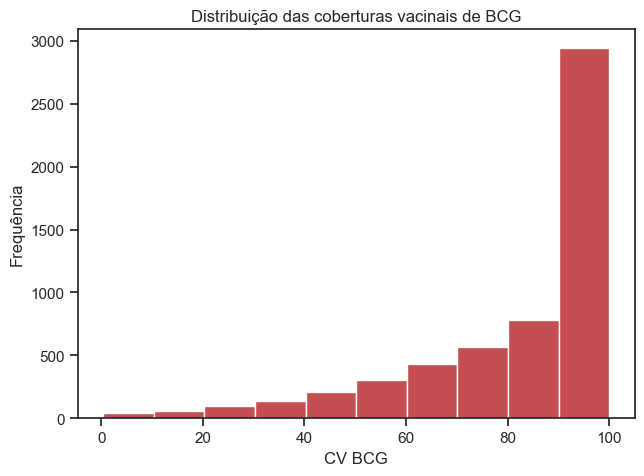

In [1041]:
# Histograma
plt.hist(dados['cv_bcg'], bins = 10, color = 'r')
plt.xlabel('CV BCG')
plt.ylabel('Frequência')
plt.title('Distribuição das coberturas vacinais de BCG')
plt.show()

In [991]:
# Análise descritiva
round(dados.describe().transpose(), 2)

,count,mean,std,min,25%,50%,75%,max
COD,5570.0,325358.63,98491.03,110001.00,251212.50,314627.50,411918.75,530010.00
cv_bcg,5562.0,83.17,21.62,0.38,72.33,92.31,100.00,100.00
prop_populacao_com_renda_menosqmeio_SM,5570.0,45.06,22.21,0.00,25.32,43.36,66.04,91.56
prop_populacao_pobreza_extrema,5570.0,10.85,11.28,0.00,1.56,5.56,18.92,54.55
Renda_media_domic_per_capita,5570.0,352.80,192.32,0.00,193.00,323.00,476.75,1807.00
Taxa_de_analfabetismo,5570.0,15.80,9.76,0.00,7.70,12.90,23.80,47.10
Taxa_de_desemprego_16a_emais,5570.0,6.32,3.69,0.00,3.80,5.81,8.15,39.15
PIB_per_capita,5570.0,17374.48,20133.34,3241.29,7077.36,12621.81,21262.39,715193.70
Saneamento_inadequado,5570.0,19.66,16.32,0.00,6.23,15.83,29.96,85.22
Taxa_urbanizacao,5570.0,63.77,22.11,0.00,47.00,64.62,82.16,100.00


In [992]:
dados_correl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5570 entries, 0 to 5569
Data columns (total 15 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   cv_bcg                                  5562 non-null   float64
 1   prop_populacao_com_renda_menosqmeio_SM  5570 non-null   float64
 2   prop_populacao_pobreza_extrema          5570 non-null   float64
 3   Renda_media_domic_per_capita            5570 non-null   int64  
 4   Taxa_de_analfabetismo                   5570 non-null   float64
 5   Taxa_de_desemprego_16a_emais            5570 non-null   float64
 6   PIB_per_capita                          5570 non-null   float64
 7   Saneamento_inadequado                   5570 non-null   float64
 8   Taxa_urbanizacao                        5570 non-null   float64
 9   Gini                                    5570 non-null   float64
 10  CoberturaESF                            5570 non-null   floa

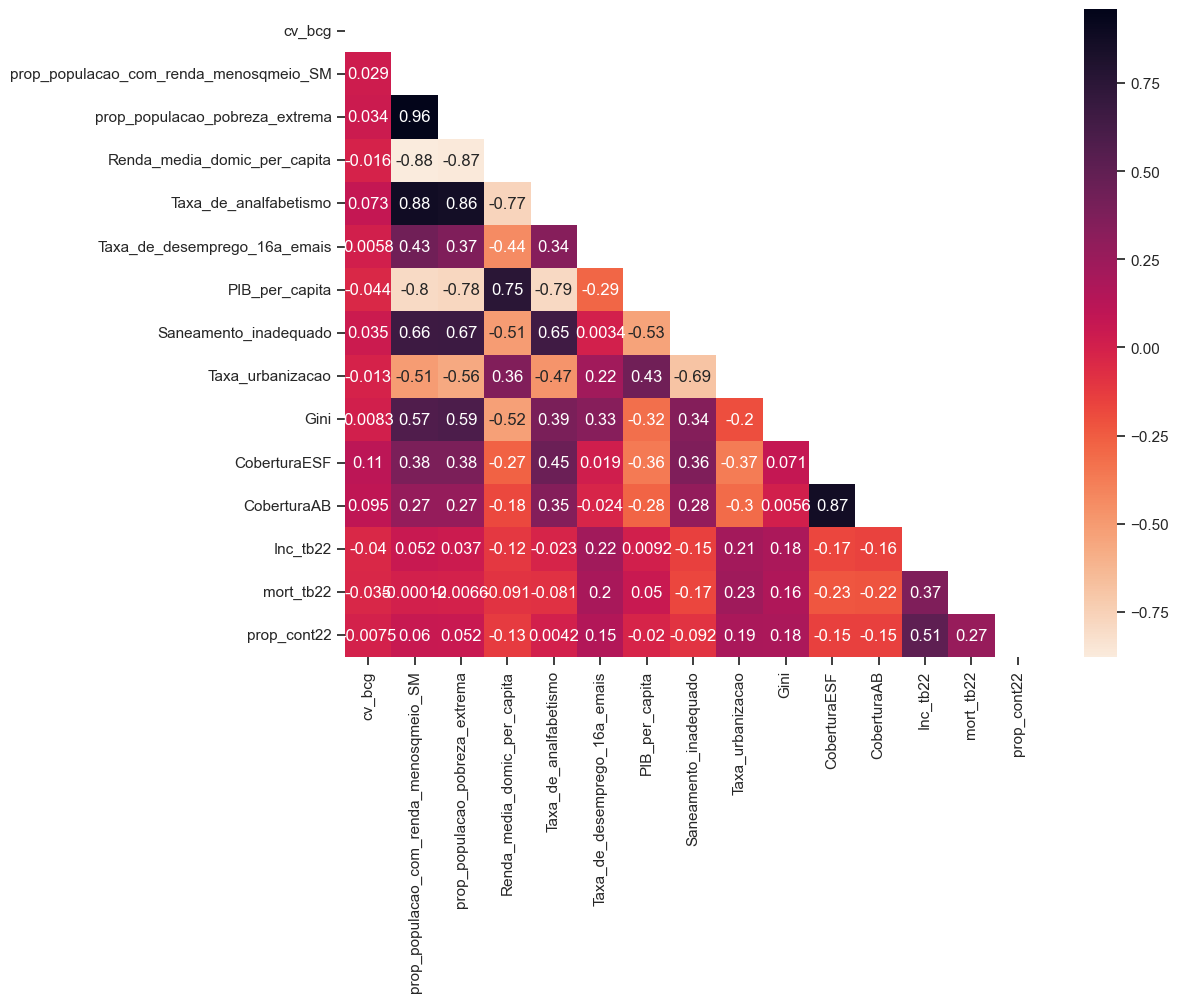

In [993]:
# Análise de correlação
dados_correl = dados.loc[:, ['cv_bcg', 'prop_populacao_com_renda_menosqmeio_SM', 'prop_populacao_pobreza_extrema', 'Renda_media_domic_per_capita', 'Taxa_de_analfabetismo', 'Taxa_de_desemprego_16a_emais', 'PIB_per_capita', 'Saneamento_inadequado', 'Taxa_urbanizacao', 'Gini', 'CoberturaESF', 'CoberturaAB', 'Inc_tb22', 'mort_tb22', 'prop_cont22']]

plt.figure(figsize=(10, 8))

corr = dados_correl.corr(method = 'spearman')

mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr, cmap = 'rocket_r', annot = True, mask = mask)

plt.show()

### Variáveis preditoras com r de Speraman > 0,6 retiradas da análise
* Saneamento inadequado
* PIB per pcapita
* Renda média domiciliar per capita
* Cobertura AB
* Taxa analfabetismo
* Pobreza extrema (%)

In [994]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5570 entries, 0 to 5569
Data columns (total 18 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   COD                                     5570 non-null   int64  
 1   MUNI                                    5570 non-null   object 
 2   cv_bcg                                  5562 non-null   float64
 3   prop_populacao_com_renda_menosqmeio_SM  5570 non-null   float64
 4   prop_populacao_pobreza_extrema          5570 non-null   float64
 5   Renda_media_domic_per_capita            5570 non-null   int64  
 6   Taxa_de_analfabetismo                   5570 non-null   float64
 7   Taxa_de_desemprego_16a_emais            5570 non-null   float64
 8   PIB_per_capita                          5570 non-null   float64
 9   Saneamento_inadequado                   5570 non-null   float64
 10  Taxa_urbanizacao                        5570 non-null   floa

In [1043]:
# Dados de análise
dados2 = dados.loc[:, ['cv_bcg', 'prop_populacao_com_renda_menosqmeio_SM', 'Taxa_de_desemprego_16a_emais', 'Taxa_urbanizacao', 'Gini', 'CoberturaESF', 'Inc_tb22', 'mort_tb22', 'prop_cont22']]
dados2.head()

,cv_bcg,prop_populacao_com_renda_menosqmeio_SM,Taxa_de_desemprego_16a_emais,Taxa_urbanizacao,Gini,CoberturaESF,Inc_tb22,mort_tb22,prop_cont22
0,100.0,48.42,5.01,57.27,58.93,90.22,4.441286,4.441286,40.000000
1,100.0,31.05,4.64,84.70,54.96,44.78,24.291935,1.799403,78.571426
2,94.2,48.17,2.49,42.66,51.66,100.00,39.471088,0.000000,0.000000
3,100.0,32.10,5.87,78.81,58.90,68.71,17.357897,0.000000,84.210526
4,100.0,36.99,5.24,84.67,51.47,84.54,18.647440,0.000000,100.000000


# Modelos supervisionados

## Random Forest para regressão

# Modelo 1
#### Modelo ajustado considerando a multicolinearidade

In [1044]:
# Converter as variáveis em arrays
# Variável resposta
y = dados2['cv_bcg']
y = np.nan_to_num(y, nan=0)

# Remover os rótulos das variáveis
# O eixo (axis) 1 se refere às colunas
X = dados2.drop('cv_bcg', axis = 1)
# Saving feature names for later use

In [1045]:
# Dividir dados em conjunto de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)

In [1046]:
# Forma dos dados de treino e teste
print('Formato dos dados de treino:', X_train.shape)
print('Formato da variável resposta de treino:', y_train.shape)
print('Formato dos dados de teste:', X_test.shape)
print('Formato da variável resposta de teste:', y_test.shape)

Formato dos dados de treino: (3899, 8)
Formato da variável resposta de treino: (3899,)
Formato dos dados de teste: (1671, 8)
Formato da variável resposta de teste: (1671,)


In [1047]:
# Estabelecendo linha de base
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

lr.fit(X, y)

lr_pred = lr.predict(X)

print('Mean Absolute Error:', mean_absolute_error(y, lr_pred))
print("Mean Squared Error:", mean_squared_error(y, lr_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y, lr_pred)))

Mean Absolute Error: 17.222232654444884
Mean Squared Error: 472.1369210861659
Root Mean Squared Error: 21.72871190582097


In [1048]:
# Criar objeto random forest regression
rfr = RandomForestRegressor(n_estimators = 1000, min_samples_leaf=3, max_depth=4, n_jobs=-1, random_state = 123)
rfr.fit(X_train, y_train)

RandomForestRegressor(max_depth=4, min_samples_leaf=3, n_estimators=1000,
                      n_jobs=-1, random_state=123)

In [1049]:
# Realizar a predição
y_pred = rfr.predict(X_test)

# Calculate the absolute errors
errors = abs(y_pred - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 17.25 degrees.


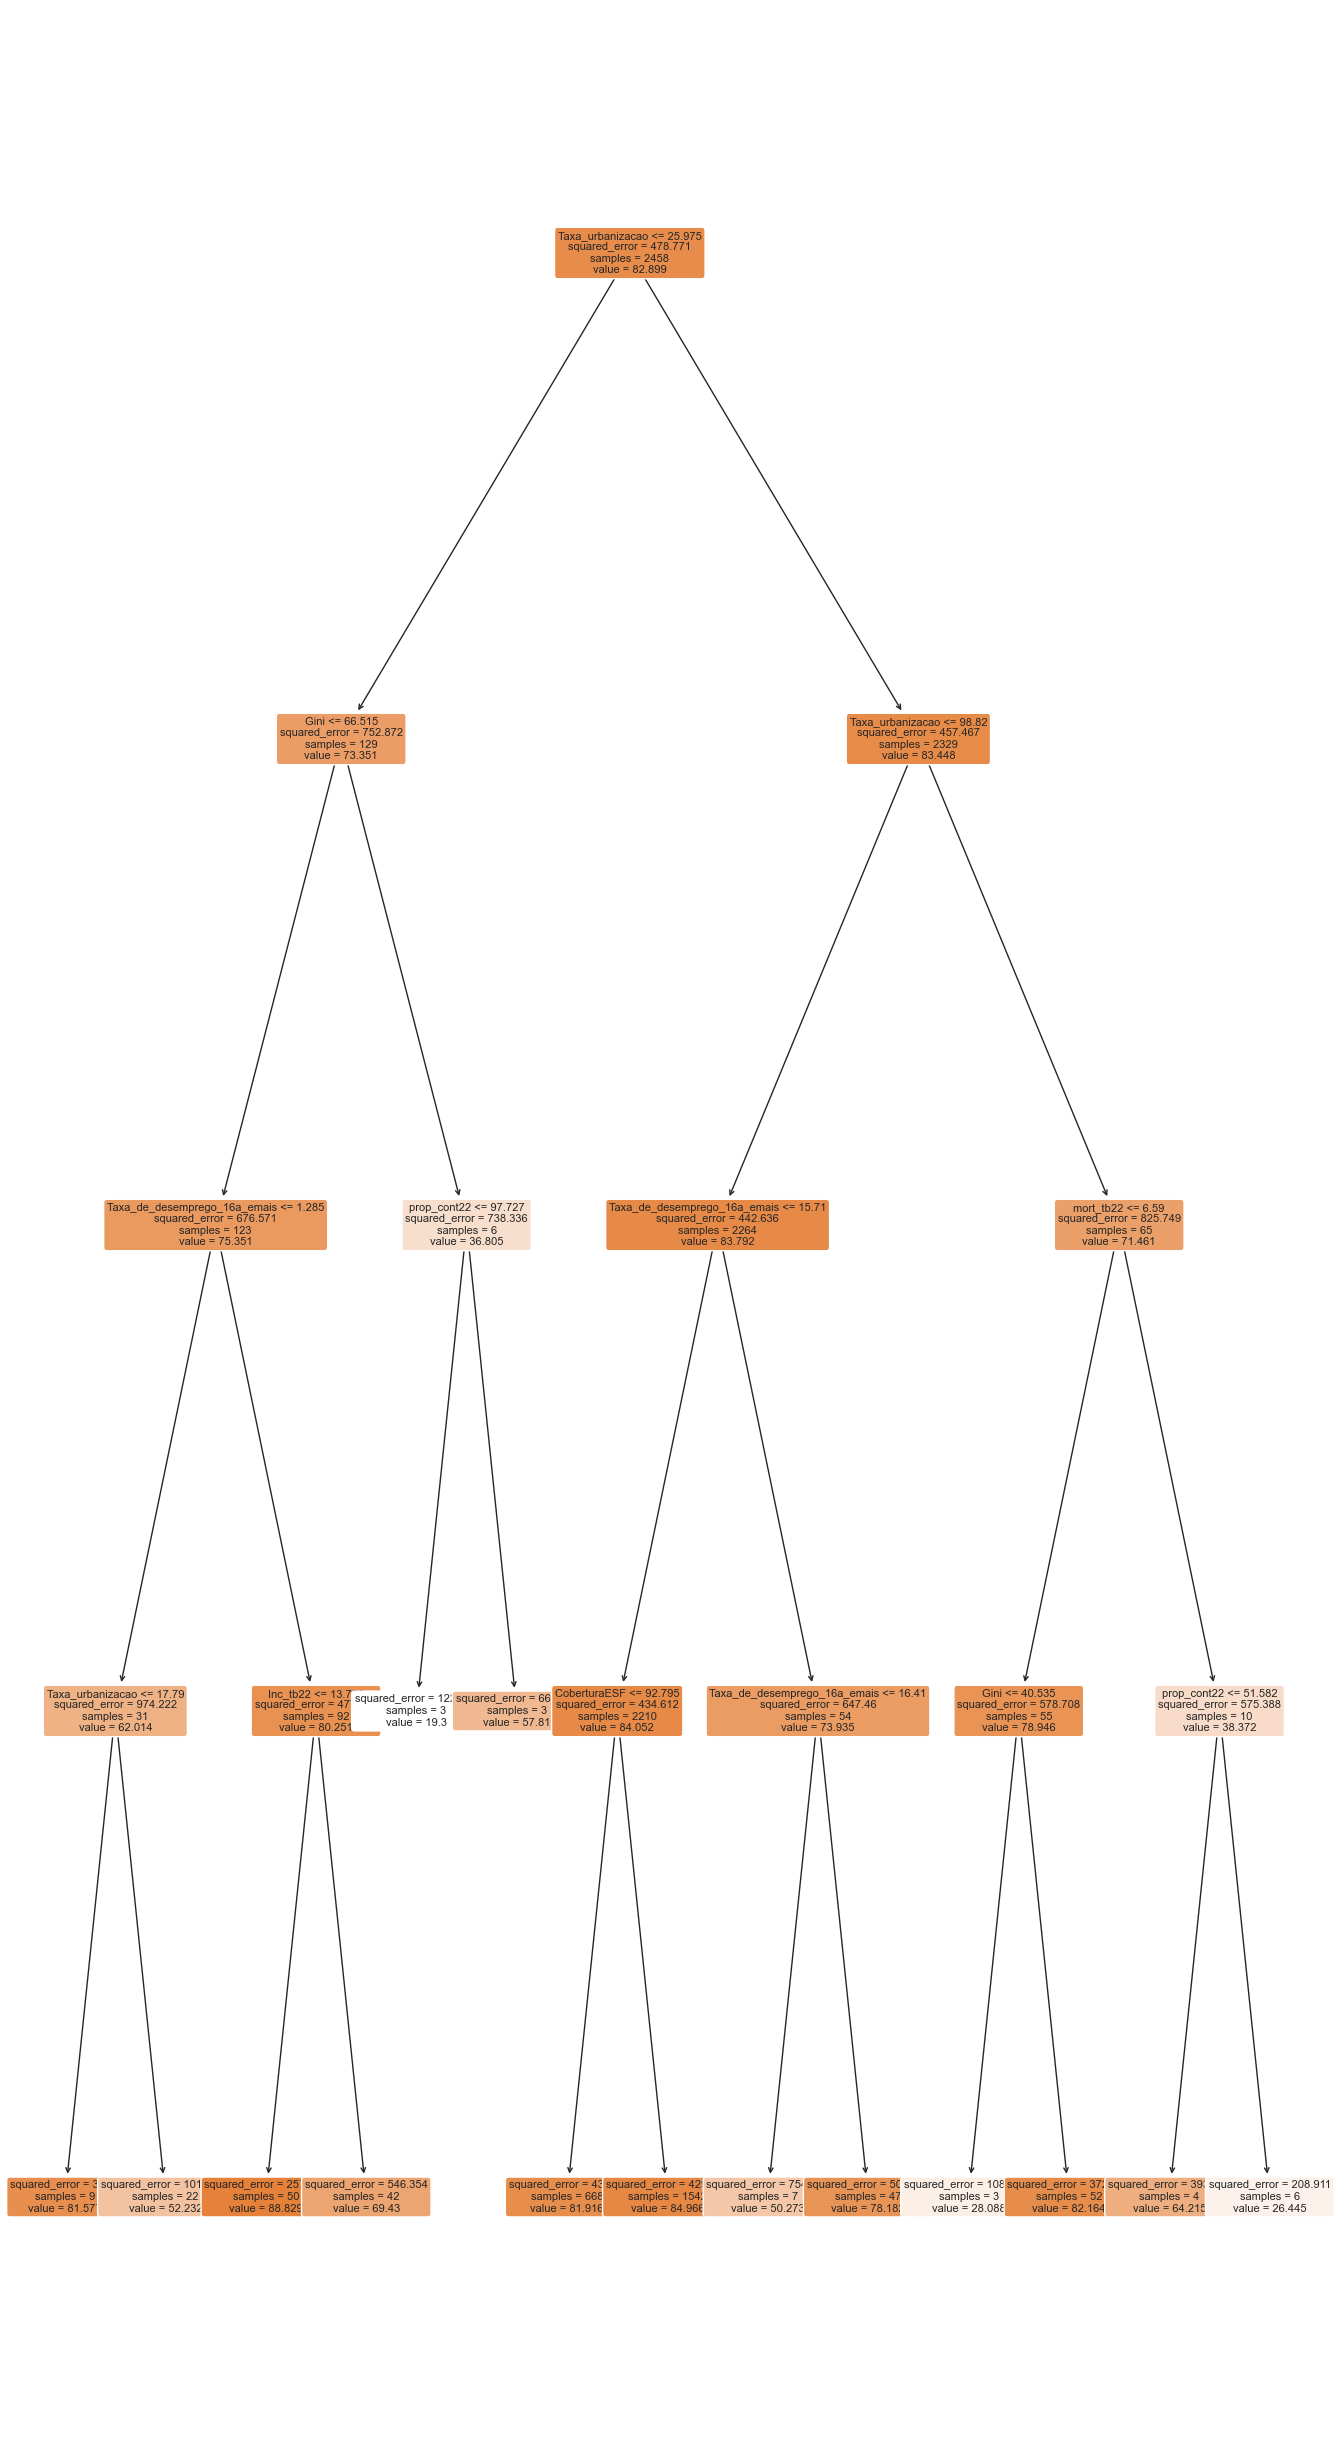

In [1050]:
from sklearn import tree

features = X.columns
# Obtain just the first tree
first_tree = rfr.estimators_[0]

plt.figure(figsize=(15,30))
tree.plot_tree(first_tree,
               feature_names=features,
               fontsize=8, 
               filled=True, 
               rounded=True);

In [1051]:
from sklearn.metrics import mean_squared_error, r2_score

# Avaliar o desempenho nos dados de treinamento
y_train_pred = rfr.predict(X_train)
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
train_r2 = r2_score(y_train, y_train_pred)
print("Desempenho dos dados de treinamento")
print('Mean Absolute Error (MAE):', mean_absolute_error(y_train, y_train_pred))
print('Mean Squared Error (MSE):', mean_squared_error(y_train, y_train_pred))
print("Root Mean Squared Error (RMSE): ", train_rmse)
print("R2: ", train_r2)

Desempenho dos dados de treinamento
Mean Absolute Error (MAE): 16.667730044747596
Mean Squared Error (MSE): 441.4034719150056
Root Mean Squared Error (RMSE):  21.00960427792503
R2:  0.06790916325716423


* Com 8 recursos
esempenho dos dados de treinamento
Mean Absolute Error (MAE): 16.449060949778936
Mean Squared Error (MSE): 430.1290790221959
Root Mean Squared Error (RMSE):  20.73955349138925
R2:  0.091716765539119

In [1052]:
# Avaliar o desempenho nos dados de teste
y_test_pred = rfr.predict(X_test)
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
test_r2 = r2_score(y_test, y_test_pred)
print("Desempenho dos dados de teste")
print('Mean Absolute Error (MAE):', mean_absolute_error(y_test, y_test_pred))
print('Mean Squared Error (MSE):', mean_squared_error(y_test, y_test_pred))
print("Root Mean Squared Error (RMSE): ", test_rmse)
print("R2: ", test_r2)

Desempenho dos dados de teste
Mean Absolute Error (MAE): 17.249550806437206
Mean Squared Error (MSE): 482.0581804937449
Root Mean Squared Error (RMSE):  21.955823384554378
R2:  0.00394153347667936


In [1053]:
# Get numerical feature importances
importances = list(rfr.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(X_train, round(importance, 2)) for X_train, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Taxa_urbanizacao     Importance: 0.31
Variable: prop_populacao_com_renda_menosqmeio_SM Importance: 0.28
Variable: Taxa_de_desemprego_16a_emais Importance: 0.09
Variable: Inc_tb22             Importance: 0.09
Variable: Gini                 Importance: 0.08
Variable: CoberturaESF         Importance: 0.07
Variable: mort_tb22            Importance: 0.05
Variable: prop_cont22          Importance: 0.02


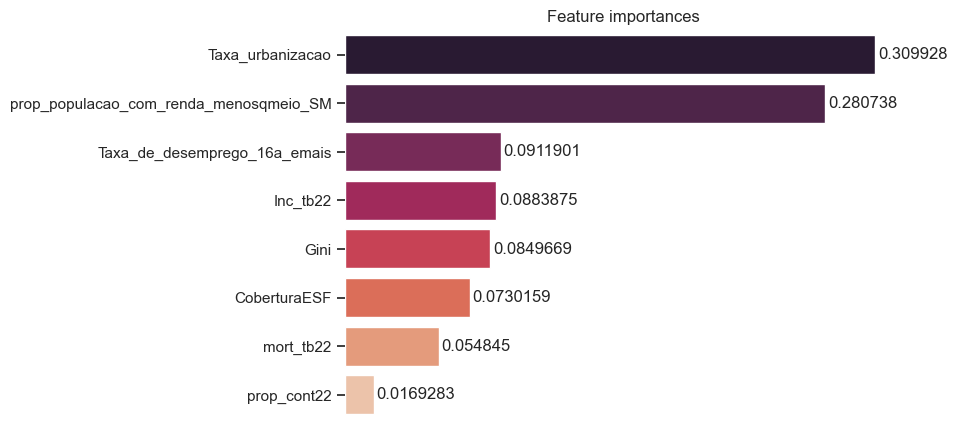

In [1054]:
# Organizing feature names and importances in a DataFrame
features_df = pd.DataFrame({'features': rfr.feature_names_in_, 'importances': rfr.feature_importances_ })

# Sorting data from highest to lowest
features_df_sorted = features_df.sort_values(by='importances', ascending=False)

# Barplot of the result without borders and axis lines
g = sns.barplot(data=features_df_sorted, x='importances', y ='features', palette="rocket")
sns.despine(bottom = True, left = True)
g.set_title('Feature importances')
g.set(xlabel=None)
g.set(ylabel=None)
g.set(xticks=[])
for value in g.containers:
    g.bar_label(value, padding=2)

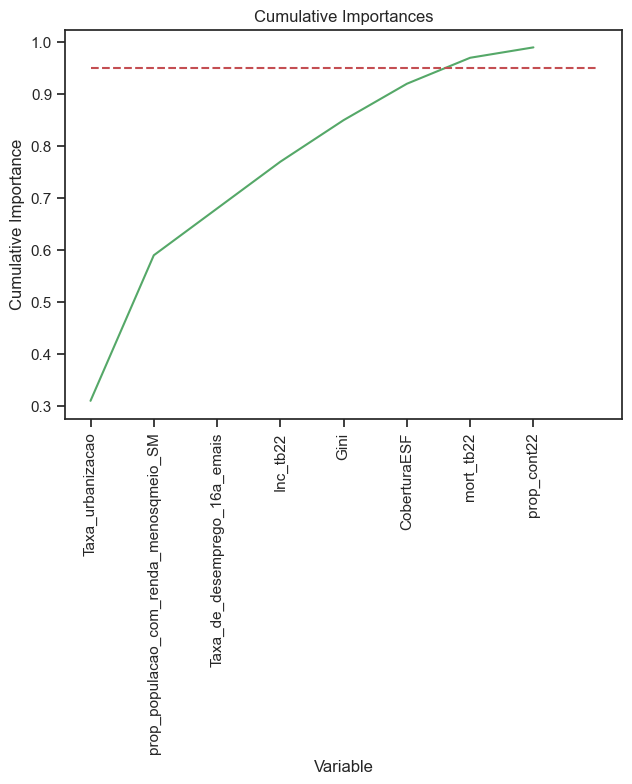

In [1055]:
x_values = list(range(len(features_df)))

# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]
# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)
# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')
# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')
# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')
# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');

In [1008]:
# Find number of features for cumulative importance of 95%
# Add 1 because Python is zero-indexed
print('Number of features for 95% importance:', np.where(cumulative_importances > 0.95)[0][0] + 1)

Number of features for 95% importance: 7


# Modelo 2
#### Ajuste do modelo fazendo engenharia de recursos (pela importância das variáveis)

In [1009]:
# Dados de análise
dados_important = dados.loc[:, ['cv_bcg', 'prop_populacao_com_renda_menosqmeio_SM', 'Taxa_de_desemprego_16a_emais', 'Taxa_urbanizacao', 'Gini', 'CoberturaESF', 'Inc_tb22']]

# Converter as variáveis em arrays
# Variável resposta
y_imp = dados2['cv_bcg']
y_imp = np.nan_to_num(y, nan=0)

# Remover os rótulos das variáveis
# O eixo (axis) 1 se refere às colunas
X_imp = dados_important.drop('cv_bcg', axis = 1)
# Saving feature names for later use

# Dividir dados em conjunto de treino e teste
X_train_imp, X_test_imp, y_train_imp, y_test_imp = train_test_split(X_imp, y_imp, test_size = 0.3, random_state = 123)



In [1010]:
# Train the expanded model on only the important features
# Criar objeto random forest regression
rfr.fit(X_train_imp, y_train_imp);
# Make predictions on test data
y_pred_imp = rfr.predict(X_test_imp)
# Performance metrics
errors = abs(y_pred_imp - y_test_imp)
print('Average absolute error:', round(np.mean(errors), 2), 'degrees.')
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test_imp)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Average absolute error: 17.27 degrees.
Accuracy: -inf %.


In [1011]:
# Avaliar o desempenho nos dados de treinamento
y_train_pred_imp = rfr.predict(X_train_imp)
train_rmse_imp = mean_squared_error(y_train_imp, y_train_pred_imp, squared=False)
train_r2_imp = r2_score(y_train_imp, y_train_pred_imp)
print("Desempenho dos dados de treinamento")
print('Mean Absolute Error (MAE):', mean_absolute_error(y_train_imp, y_train_pred_imp))
print('Mean Squared Error (MSE):', mean_squared_error(y_train_imp, y_train_pred_imp))
print("Root Mean Squared Error (RMSE): ", train_rmse_imp)
print("R2: ", train_r2_imp)

Desempenho dos dados de treinamento
Mean Absolute Error (MAE): 16.680473226213348
Mean Squared Error (MSE): 442.24697227185584
Root Mean Squared Error (RMSE):  21.029668857874483
R2:  0.06612798344451243


In [1012]:
# Avaliar o desempenho nos dados de teste
y_test_pred_imp = rfr.predict(X_test_imp)
test_rmse_imp = mean_squared_error(y_test_imp, y_test_pred_imp, squared=False)
test_r2_imp = r2_score(y_test_imp, y_test_pred_imp)
print("Desempenho dos dados de teste")
print('Mean Absolute Error (MAE):', mean_absolute_error(y_test_imp, y_test_pred_imp))
print('Mean Squared Error (MSE):', mean_squared_error(y_test_imp, y_test_pred_imp))
print("Root Mean Squared Error (RMSE): ", test_rmse_imp)
print("R2: ", test_r2_imp)

Desempenho dos dados de teste
Mean Absolute Error (MAE): 17.27471322415566
Mean Squared Error (MSE): 483.0175667864045
Root Mean Squared Error (RMSE):  21.977660630431178
R2:  0.0019591901037462334


In [1013]:
# Get numerical feature importances
importances = list(rfr.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(X_train_imp, round(importance, 2)) for X_train_imp, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Taxa_urbanizacao     Importance: 0.33
Variable: prop_populacao_com_renda_menosqmeio_SM Importance: 0.29
Variable: Taxa_de_desemprego_16a_emais Importance: 0.1
Variable: Inc_tb22             Importance: 0.1
Variable: Gini                 Importance: 0.09
Variable: CoberturaESF         Importance: 0.08


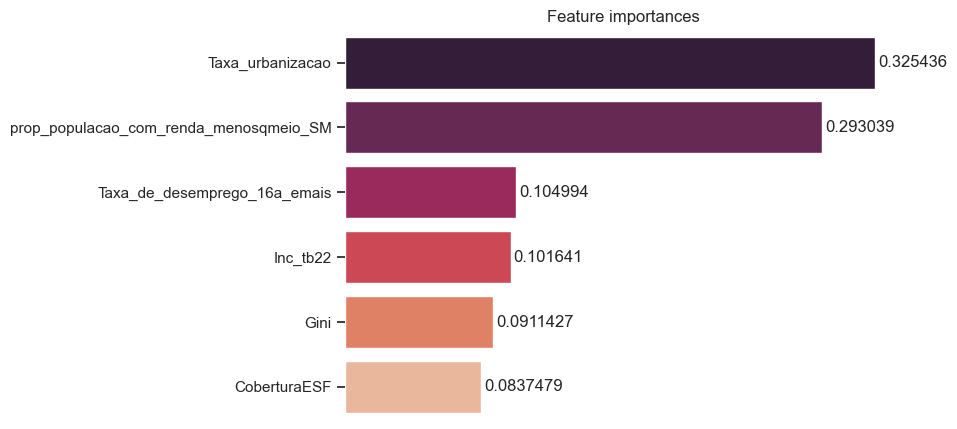

In [1014]:
# Organizing feature names and importances in a DataFrame
features_df = pd.DataFrame({'features': rfr.feature_names_in_, 'importances': rfr.feature_importances_ })

# Sorting data from highest to lowest
features_df_sorted = features_df.sort_values(by='importances', ascending=False)

# Barplot of the result without borders and axis lines
g = sns.barplot(data=features_df_sorted, x='importances', y ='features', palette="rocket")
sns.despine(bottom = True, left = True)
g.set_title('Feature importances')
g.set(xlabel=None)
g.set(ylabel=None)
g.set(xticks=[])
for value in g.containers:
    g.bar_label(value, padding=2)

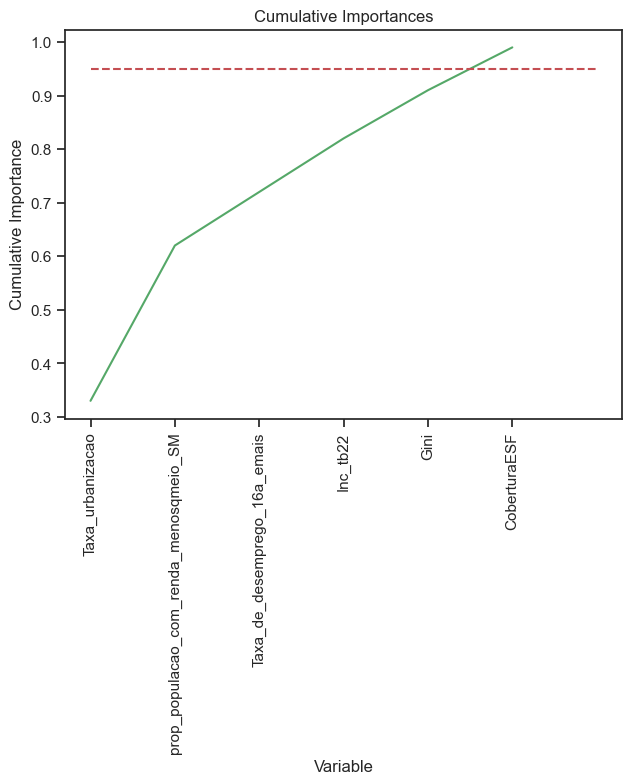

In [1015]:
x_values = list(range(len(features_df)))

# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]
# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)
# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')
# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')
# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')
# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');

In [1016]:
# Find number of features for cumulative importance of 95%
# Add 1 because Python is zero-indexed
print('Number of features for 95% importance:', np.where(cumulative_importances > 0.95)[0][0] + 1)

Number of features for 95% importance: 6


# Modello 3

#### Ajuste de hiperparâmetros

In [1017]:
rfr = RandomForestRegressor(random_state=123)

# Look at parameters used by our current forest
print('Parameters currently in use:\n')
print(rfr.get_params())

Parameters currently in use:

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False}


In [1018]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [1019]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=123, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=123, verbose=2)

In [1020]:
rf_random.best_params_

{'n_estimators': 1200,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': True}

In [1056]:
from sklearn.metrics import mean_squared_error, r2_score

# Avaliar o desempenho nos dados de treinamento
y_train_pred = rf_random.predict(X_train)
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
train_r2 = r2_score(y_train_imp, y_train_pred)
print("Desempenho dos dados de treinamento")
print('Mean Absolute Error (MAE):', mean_absolute_error(y_train, y_train_pred))
print('Mean Squared Error (MSE):', mean_squared_error(y_train, y_train_pred))
print("Root Mean Squared Error (RMSE): ", train_rmse)
print("R2: ", train_r2)

Desempenho dos dados de treinamento
Mean Absolute Error (MAE): 15.35762096152038
Mean Squared Error (MSE): 378.292422186062
Root Mean Squared Error (RMSE):  19.44974092850756
R2:  0.20117778231527805


In [1057]:
# Avaliar o desempenho nos dados de teste
y_test_pred = rf_random.predict(X_test)
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
test_r2 = r2_score(y_test_imp, y_test_pred)
print("Desempenho dos dados de teste")
print('Mean Absolute Error (MAE):', mean_absolute_error(y_test, y_test_pred))
print('Mean Squared Error (MSE):', mean_squared_error(y_test, y_test_pred))
print("Root Mean Squared Error (RMSE): ", test_rmse)
print("R2: ", test_r2)

Desempenho dos dados de teste
Mean Absolute Error (MAE): 17.210996401308115
Mean Squared Error (MSE): 479.02968774993934
Root Mean Squared Error (RMSE):  21.88674685168948
R2:  0.010199192739265173


In [1058]:
best_model = rf_random.best_estimator_

importances = best_model.feature_importances_

indices = np.argsort(importances[::1])

for i, feature in enumerate(X_train.columns[indices]):
    print(f"{i + 1}. {feature}: {importances[indices[i]]}")

1. prop_cont22: 0.04333270694350071
2. mort_tb22: 0.05527499800616278
3. CoberturaESF: 0.08198349764908618
4. Inc_tb22: 0.1171496664932131
5. Gini: 0.14951717347191562
6. Taxa_de_desemprego_16a_emais: 0.1543358362963987
7. prop_populacao_com_renda_menosqmeio_SM: 0.1953245729422038
8. Taxa_urbanizacao: 0.20308154819751922


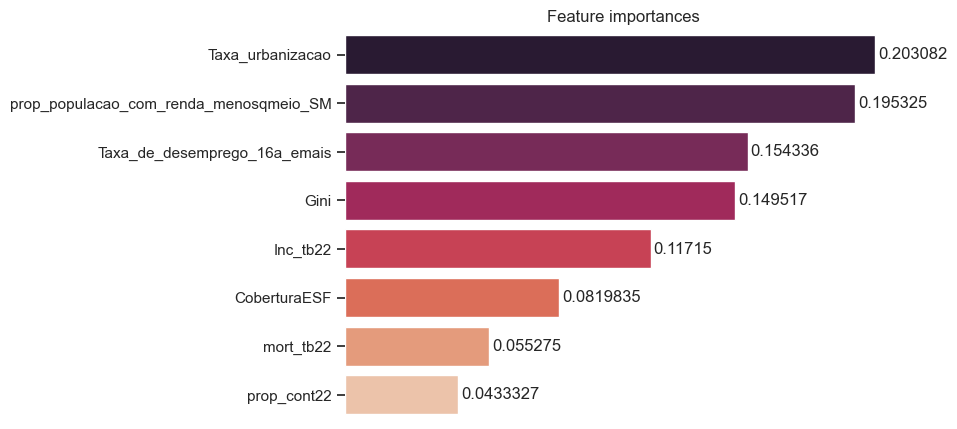

In [1059]:
# Organizing feature names and importances in a DataFrame
features_df = pd.DataFrame({'features': best_model.feature_names_in_, 'importances': best_model.feature_importances_ })

# Sorting data from highest to lowest
features_df_sorted = features_df.sort_values(by='importances', ascending=False)

# Barplot of the result without borders and axis lines
g = sns.barplot(data=features_df_sorted, x='importances', y ='features', palette="rocket")
sns.despine(bottom = True, left = True)
g.set_title('Feature importances')
g.set(xlabel=None)
g.set(ylabel=None)
g.set(xticks=[])
for value in g.containers:
    g.bar_label(value, padding=2)

# Clustering

In [1061]:
# Teste da Bartlett
from scipy.stats import bartlett

x1 = dados2['prop_populacao_com_renda_menosqmeio_SM']
x2 = dados2['Taxa_urbanizacao']
x3 = dados2['Taxa_de_desemprego_16a_emais']
x4 = dados2['Gini']
x5 = dados2['Inc_tb22']

resultado = bartlett(x1, x2, x3, x4, x5)
print(resultado)


BartlettResult(statistic=24770.807212200405, pvalue=0.0)


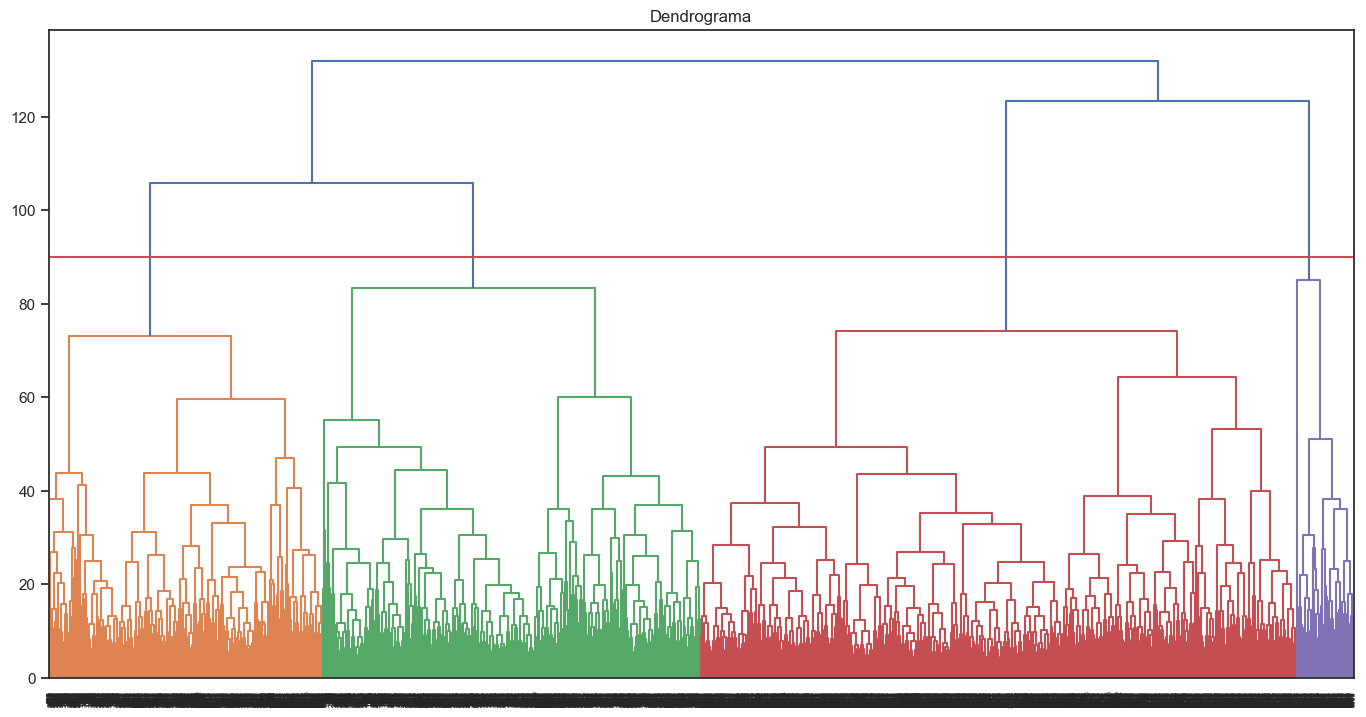

In [1085]:
dados_clust = dados2.drop(['cv_bcg', 'CoberturaESF', 'Inc_tb22', 'mort_tb22', 'prop_cont22'], axis = 1)
#dados_clust = dados_reg.drop('cv_bcg_tabnet', axis = 1)

# Cluster hierárquico
plt.figure(figsize=(15, 8))
plt.title("Dendrograma")

# Selecting Annual Income and Spending Scores by index
clusters = shc.linkage(dados_clust, 
            method='complete', 
            metric="euclidean")
shc.dendrogram(Z=clusters)
plt.axhline(y = 90, color = 'r', linestyle = '-')
plt.show()

In [1086]:
cluster_H = shc.fcluster(clusters, t = 4, criterion='maxclust')

dados['cluster_H'] = cluster_H

tabela_freq = pd.crosstab(index = dados['cluster_H'], columns='contagem')

print(tabela_freq)

col_0      contagem
cluster_H          
1              1171
2              1614
3              2543
4               242


In [1087]:
dados_clust.head()

,prop_populacao_com_renda_menosqmeio_SM,Taxa_de_desemprego_16a_emais,Taxa_urbanizacao,Gini
0,48.42,5.01,57.27,58.93
1,31.05,4.64,84.70,54.96
2,48.17,2.49,42.66,51.66
3,32.10,5.87,78.81,58.90
4,36.99,5.24,84.67,51.47


In [1068]:
from scipy.stats import f_oneway

groups = [dados_clust[cluster_H == i] for i in np.unique(cluster_H)]
f_stat, p_value = f_oneway(*groups)

print("Estatística F: ", f_stat)
print("Valor-p: ", p_value)

Estatística F:  [4968.49248883  632.52033952 3149.52063057  616.61906376]
Valor-p:  [0. 0. 0. 0.]


In [1069]:
# Teste ANOVA
anova_results = []

for i in range(dados_clust.shape[1]):
    groups = [dados_clust.iloc[cluster_H == j, i] for j in np.unique(cluster_H)]
    
    f_stat, p_value = f_oneway(*groups)

    anova_results.append((f_stat, p_value))

for i, (f_stat, p_value) in enumerate(anova_results):
    var_name = f'Variable {i+1}'
    print(f'{var_name}:')
    print(f' Estatística F:{f_stat:.3f}')
    print(f' Valor-p: {p_value:.3f}')

Variable 1:
 Estatística F:4968.492
 Valor-p: 0.000
Variable 2:
 Estatística F:632.520
 Valor-p: 0.000
Variable 3:
 Estatística F:3149.521
 Valor-p: 0.000
Variable 4:
 Estatística F:616.619
 Valor-p: 0.000


In [1070]:
dados['cluster_H'] = dados['cluster_H'].astype(str)

In [1091]:
var=list(['cv_bcg', 'Taxa_urbanizacao', 'prop_populacao_com_renda_menosqmeio_SM', 'Taxa_de_desemprego_16a_emais', 'Gini'])

medias_var = dados.groupby(['cluster_H'], as_index=False)[var].mean()
sd_var = dados.groupby(['cluster_H'], as_index=False)[var].std()

# Estatísticas
print('Média:', round(medias_var.T, 2))
print('Desvio padrão:', round(sd_var.T, 2))

Média:                                             0      1      2      3
cluster_H                                1.00   2.00   3.00   4.00
cv_bcg                                  81.49  84.64  83.13  81.82
Taxa_urbanizacao                        34.48  67.14  77.79  35.68
prop_populacao_com_renda_menosqmeio_SM  63.30  64.33  27.10  16.93
Taxa_de_desemprego_16a_emais             6.02   8.89   5.29   1.46
Gini                                    53.00  53.95  47.31  43.38
Desvio padrão:                                             0      1      2      3
cluster_H                                1.00   2.00   3.00   4.00
cv_bcg                                  23.35  20.72  21.07  23.92
Taxa_urbanizacao                         9.47  13.97  14.88  10.59
prop_populacao_com_renda_menosqmeio_SM  14.27  10.37  11.25   7.55
Taxa_de_desemprego_16a_emais             3.72   3.89   2.46   1.36
Gini                                     5.76   5.58   5.78   8.90


In [1092]:
quartis = dados.groupby('cluster_H')[var].quantile([0.25, 0.5, 0.75]).reset_index()
print('Quartis:', round(quartis.T, 2))

Quartis:                                            0      1       2      3      4    
cluster_H                                1.00   1.00    1.00   2.00   2.00  \
level_1                                  0.25   0.50    0.75   0.25   0.50   
cv_bcg                                  68.97  91.78  100.00  73.91  95.82   
Taxa_urbanizacao                        28.22  35.36   41.29  56.25  65.20   
prop_populacao_com_renda_menosqmeio_SM  54.68  66.73   74.12  58.23  65.74   
Taxa_de_desemprego_16a_emais             3.60   5.43    7.86   6.30   8.17   
Gini                                    48.89  52.58   56.64  50.22  53.57   

                                            5      6      7       8      9    
cluster_H                                 2.00   3.00   3.00    3.00   4.00  \
level_1                                   0.75   0.25   0.50    0.75   0.25   
cv_bcg                                  100.00  73.86  90.40  100.00  69.36   
Taxa_urbanizacao                         77.88  65

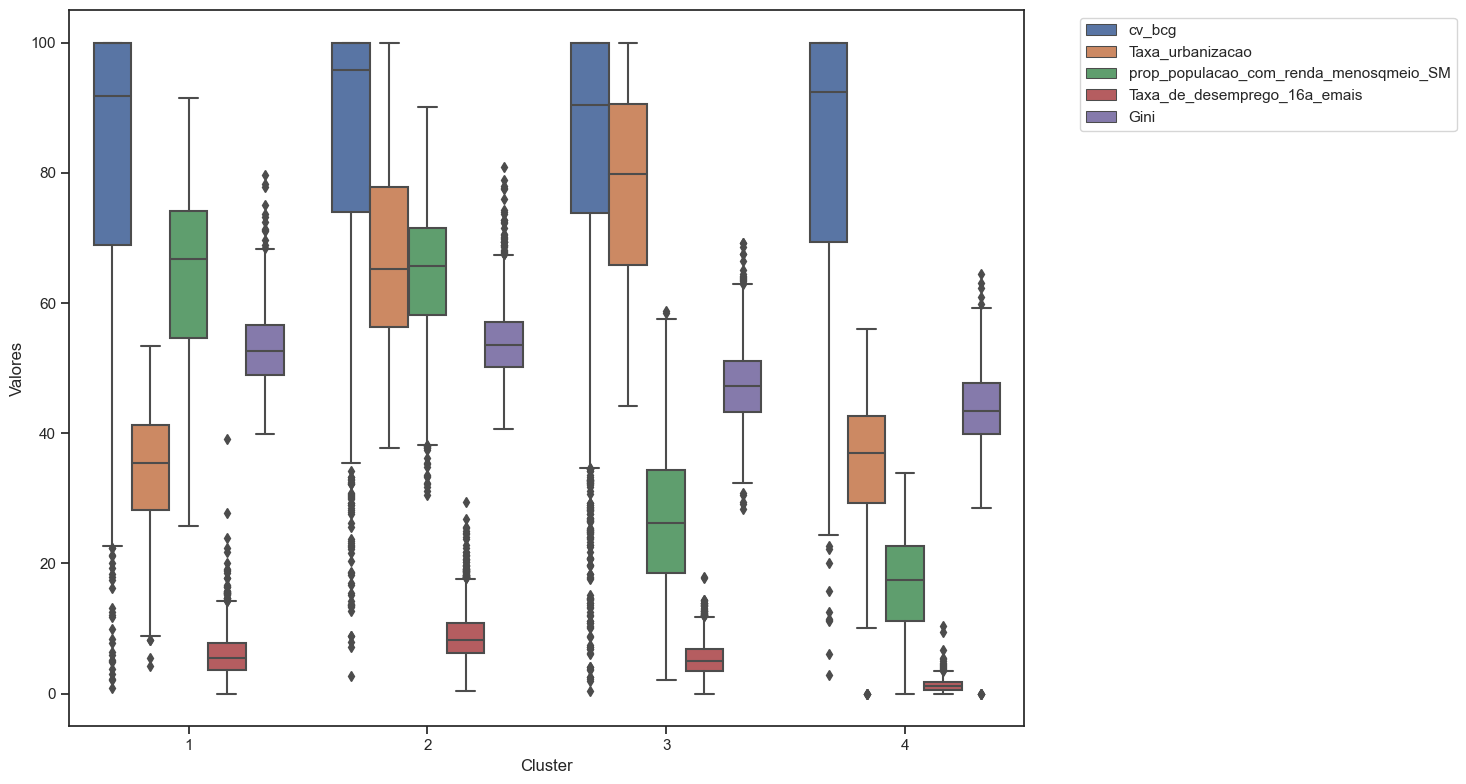

In [1093]:
dados_box = dados.loc[:, ['cv_bcg', 'Taxa_urbanizacao', 'prop_populacao_com_renda_menosqmeio_SM', 'Taxa_de_desemprego_16a_emais', 'Gini', 'cluster_H']]
dados_melt = dados_box.melt(id_vars='cluster_H', var_name='Variable', value_name='Value')

plt.figure(figsize=(15, 8))
sns.boxplot(data=dados_melt, x = 'cluster_H', y = 'Value', hue='Variable')
plt.xlabel('Cluster')
plt.ylabel('Valores')
plt.legend(bbox_to_anchor=(1.05, 1), loc = 'upper left')
plt.tight_layout()

plt.show()

## Geoprocessamento

In [1079]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5570 entries, 0 to 5569
Data columns (total 19 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   COD                                     5570 non-null   object 
 1   MUNI                                    5570 non-null   object 
 2   cv_bcg                                  5562 non-null   float64
 3   prop_populacao_com_renda_menosqmeio_SM  5570 non-null   float64
 4   prop_populacao_pobreza_extrema          5570 non-null   float64
 5   Renda_media_domic_per_capita            5570 non-null   int64  
 6   Taxa_de_analfabetismo                   5570 non-null   float64
 7   Taxa_de_desemprego_16a_emais            5570 non-null   float64
 8   PIB_per_capita                          5570 non-null   float64
 9   Saneamento_inadequado                   5570 non-null   float64
 10  Taxa_urbanizacao                        5570 non-null   floa

In [1080]:
# importar shapefile usando geopandas
geo_br = gpd.read_file('./BR_Municipios_2022/BR_Municipios_2022.shp')
geo_br.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   CD_MUN    5572 non-null   object  
 1   NM_MUN    5572 non-null   object  
 2   SIGLA_UF  5572 non-null   object  
 3   AREA_KM2  5572 non-null   float64 
 4   geometry  5572 non-null   geometry
dtypes: float64(1), geometry(1), object(3)
memory usage: 217.8+ KB


In [1081]:
geo_br['CD_6'] = geo_br['CD_MUN'].str[:-1]
geo_br

,CD_MUN,NM_MUN,SIGLA_UF,AREA_KM2,geometry,CD_6
0,1100015,Alta Floresta D'Oeste,RO,7067.127,"POLYGON ((-62.00806 -12.13379, -62.00784 -12.2...",110001
1,1100023,Ariquemes,RO,4426.571,"POLYGON ((-63.17933 -10.13924, -63.17746 -10.1...",110002
2,1100031,Cabixi,RO,1314.352,"POLYGON ((-60.52408 -13.32137, -60.37162 -13.3...",110003
3,1100049,Cacoal,RO,3793.000,"POLYGON ((-61.35502 -11.50452, -61.35524 -11.5...",110004
4,1100056,Cerejeiras,RO,2783.300,"POLYGON ((-60.82135 -13.11910, -60.81773 -13.1...",110005
...,...,...,...,...,...,...
5567,5222005,Vianópolis,GO,954.115,"POLYGON ((-48.31126 -16.84221, -48.31170 -16.8...",522200
5568,5222054,Vicentinópolis,GO,733.794,"POLYGON ((-49.73613 -17.74427, -49.73624 -17.7...",522205
5569,5222203,Vila Boa,GO,1052.593,"POLYGON ((-47.07780 -15.06364, -47.07799 -15.0...",522220
5570,5222302,Vila Propício,GO,2181.593,"POLYGON ((-48.58713 -15.31847, -48.58714 -15.3...",522230


In [1088]:
dados['COD'] = dados['COD'].astype(str)

geo_dados = gpd.GeoDataFrame(
    pd.merge(geo_br, dados, how = 'outer',
             left_on = ["CD_6"],
             right_on = ["COD"])
)

In [1089]:
geo_dados['cluster_H'] = geo_dados['cluster_H'].astype(str)
geo_dados['cluster_H'] = geo_dados['cluster_H'].str[:-2]
geo_dados.info()
geo_dados.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 25 columns):
 #   Column                                  Non-Null Count  Dtype   
---  ------                                  --------------  -----   
 0   CD_MUN                                  5572 non-null   object  
 1   NM_MUN                                  5572 non-null   object  
 2   SIGLA_UF                                5572 non-null   object  
 3   AREA_KM2                                5572 non-null   float64 
 4   geometry                                5572 non-null   geometry
 5   CD_6                                    5572 non-null   object  
 6   COD                                     5570 non-null   object  
 7   MUNI                                    5570 non-null   object  
 8   cv_bcg                                  5562 non-null   float64 
 9   prop_populacao_com_renda_menosqmeio_SM  5570 non-null   float64 
 10  prop_populacao_pobreza_extrema          

,CD_MUN,NM_MUN,SIGLA_UF,AREA_KM2,geometry,CD_6,COD,MUNI,cv_bcg,prop_populacao_com_renda_menosqmeio_SM,...,Saneamento_inadequado,Taxa_urbanizacao,Gini,CoberturaESF,CoberturaAB,Inc_tb22,mort_tb22,prop_cont22,populacao_residente,cluster_H
0,1100015,Alta Floresta D'Oeste,RO,7067.127,"POLYGON ((-62.00806 -12.13379, -62.00784 -12.2...",110001,110001,ALTA FLORESTA D'OESTE,100.0,48.42,...,40.94,57.27,58.93,90.22,90.22,4.441286,4.441286,40.000000,22516.0,3
1,1100023,Ariquemes,RO,4426.571,"POLYGON ((-63.17933 -10.13924, -63.17746 -10.1...",110002,110002,ARIQUEMES,100.0,31.05,...,14.46,84.70,54.96,44.78,44.78,24.291935,1.799403,78.571426,111148.0,3
2,1100031,Cabixi,RO,1314.352,"POLYGON ((-60.52408 -13.32137, -60.37162 -13.3...",110003,110003,CABIXI,94.2,48.17,...,31.14,42.66,51.66,100.00,100.00,39.471088,0.000000,0.000000,5067.0,1
3,1100049,Cacoal,RO,3793.000,"POLYGON ((-61.35502 -11.50452, -61.35524 -11.5...",110004,110004,CACOAL,100.0,32.10,...,18.56,78.81,58.90,68.71,89.90,17.357897,0.000000,84.210526,86416.0,3
4,1100056,Cerejeiras,RO,2783.300,"POLYGON ((-60.82135 -13.11910, -60.81773 -13.1...",110005,110005,CEREJEIRAS,100.0,36.99,...,19.97,84.67,51.47,84.54,84.54,18.647440,0.000000,100.000000,16088.0,3


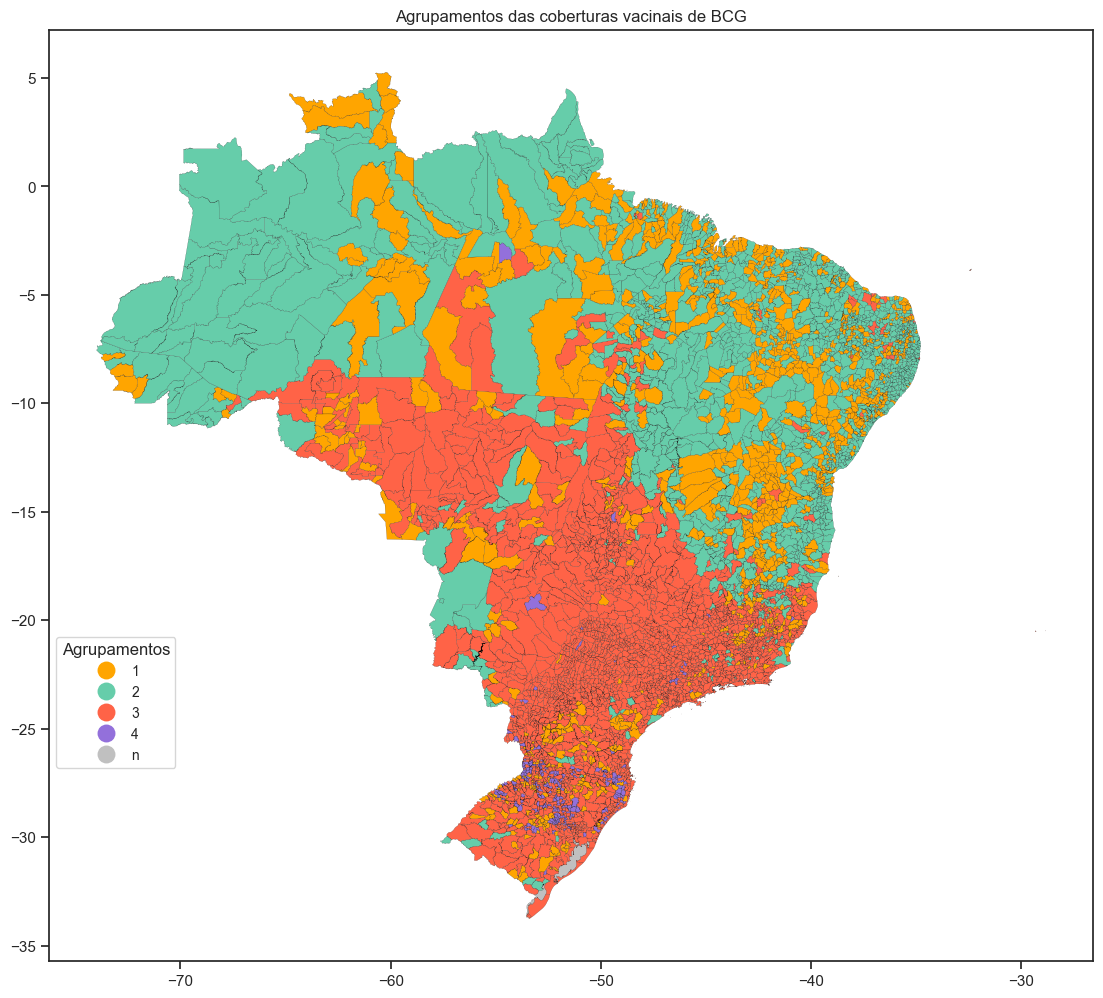

In [1090]:
from matplotlib.colors import ListedColormap

fig, ax = plt.subplots(figsize=(12, 12))

colors = ['orange', 'mediumaquamarine', 'tomato', 'mediumpurple', 'silver']

cmap = ListedColormap(colors)

# This plots choropleth map using categorical data as the theme
geo_dados.plot(column='cluster_H',     # Coluna do df
               cmap = cmap,            # Paleta de cores
               edgecolor = 'black',    # Cor das linhas
               linewidth = 0.1,        # Expessura das linhas
               alpha = 1.0,
               legend=True,
               legend_kwds={'loc':'lower left', 
                        'bbox_to_anchor':(0, .2), 
                        'markerscale':1.29, 
                        'title_fontsize':'medium', 
                        'fontsize':'small'}, 
               ax=ax
               )

leg1 = ax.get_legend()
leg1.set_title("Agrupamentos")
ax.title.set_text("Agrupamentos das coberturas vacinais de BCG")
plt.show()

# Análise de correspondência múltipla

In [823]:
# Bibliotecas
from prince import MCA

In [ ]:
mca = MCA()

mca.fit(dados)

